In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

import kornia.augmentation as K
import numpy as np
import pandas as pd
import timm
import torch
from torchgeo.models import (
    ResNet18_Weights,
    ResNet50_Weights,
    ViTSmall16_Weights,
    resnet18,
    resnet50,
    vit_small_patch16_224,
)
from tqdm import tqdm

from src.portal.datamodule import LandsatDataModule
from src.portal.datamodule_sentinel import SentinelDataModule
from src.portal.datasets.eurosat import dataset_sentinel, dataset_statistics
from src.portal.embedding import extract_features
from src.portal.evaluation import eval_knn

output_dir = "embeddings"
os.makedirs(output_dir, exist_ok=True)

k = 5
device = torch.device("cuda")

root = "data"
dm = LandsatDataModule(
    name="eurosat", root=root, batch_size=16, num_workers=8, download=True
)
dm.prepare_data()

## Models

In [5]:
def create_model(model_name, weights, **kwargs):
    model = timm.create_model(model_name, pretrained=False, **kwargs)
    state_dict = weights.get_state_dict(progress=True)
    if "norm.weight" in state_dict:
        state_dict["fc_norm.weight"] = state_dict["norm.weight"]
        state_dict["fc_norm.bias"] = state_dict["norm.bias"]
        del state_dict["norm.weight"]
        del state_dict["norm.bias"]
    model.load_state_dict(state_dict, strict=False)
    return model

In [ ]:
# Imagenet transforms
mins = dataset_statistics["min"]
maxs = dataset_statistics["max"]
means = dataset_statistics["mean"] / maxs
stds = dataset_statistics["std"] / maxs
imagenet_transforms = K.ImageSequential(
    K.Normalize(mean=0.0, std=maxs),
    K.Normalize(mean=means, std=stds),
    K.Resize(224),
    keepdim=True,
)

# SSL4EO-L transforms
min = 7272.72727272727272727272
max = 18181.81818181818181818181
ssl4eol_transforms = K.ImageSequential(
    K.Normalize(mean=min, std=1.0),
    K.Normalize(mean=0.0, std=max - min),
    K.Resize(224),
    keepdim=True,
)

models_landsat = {
    "resnet18-imagenet": dict(
        model=timm.create_model,
        transforms=imagenet_transforms,
        kwargs=dict(model_name="resnet18", pretrained=True),
    ),
    "resnet50-imagenet": dict(
        model=timm.create_model,
        transforms=imagenet_transforms,
        kwargs=dict(model_name="resnet50", pretrained=True),
    ),
    "vits-imagenet": dict(
        model=timm.create_model,
        transforms=imagenet_transforms,
        kwargs=dict(model_name="vit_small_patch16_224", pretrained=True),
    ),
    "resnet18-ssl4eol-moco": dict(
        model=resnet18,
        transforms=ssl4eol_transforms,
        kwargs=dict(weights=ResNet18_Weights.LANDSAT_OLI_SR_MOCO),
    ),
    "resnet18-ssl4eol-simclr": dict(
        model=resnet18,
        transforms=ssl4eol_transforms,
        kwargs=dict(weights=ResNet18_Weights.LANDSAT_OLI_SR_SIMCLR),
    ),
    "resnet50-ssl4eol-moco": dict(
        model=resnet50,
        transforms=ssl4eol_transforms,
        kwargs=dict(weights=ResNet50_Weights.LANDSAT_OLI_SR_MOCO),
    ),
    "resnet50-ssl4eol-simclr": dict(
        model=resnet50,
        transforms=ssl4eol_transforms,
        kwargs=dict(weights=ResNet50_Weights.LANDSAT_OLI_SR_SIMCLR),
    ),
    "vits-ssl4eol-moco": dict(
        model=vit_small_patch16_224,
        transforms=ssl4eol_transforms,
        kwargs=dict(weights=ViTSmall16_Weights.LANDSAT_OLI_SR_MOCO),
    ),
    "vits-ssl4eol-simclr": dict(
        model=vit_small_patch16_224,
        transforms=ssl4eol_transforms,
        kwargs=dict(weights=ViTSmall16_Weights.LANDSAT_OLI_SR_SIMCLR),
    ),
}


# Imagenet transforms
mins = dataset_sentinel["min"]
maxs = dataset_sentinel["max"]
means = dataset_sentinel["mean"] / maxs
stds = dataset_sentinel["std"] / maxs
imagenet_transforms = K.ImageSequential(
    K.Normalize(mean=0.0, std=maxs),
    K.Normalize(mean=means, std=stds),
    K.Resize(224),
    keepdim=True,
)

ssl4eol_transforms = K.ImageSequential(
    K.Normalize(mean=torch.tensor(0.0), std=torch.tensor(10000.0)),
    K.Resize(224),
    keepdim=True,
)

models_sentinel = {
    "resnet18-imagenet": dict(
        model=timm.create_model,
        transforms=imagenet_transforms,
        kwargs=dict(model_name="resnet18", pretrained=True),
    ),
    "resnet50-imagenet": dict(
        model=timm.create_model,
        transforms=imagenet_transforms,
        kwargs=dict(model_name="resnet50", pretrained=True),
    ),
    "vits-imagenet": dict(
        model=timm.create_model,
        transforms=imagenet_transforms,
        kwargs=dict(model_name="vit_small_patch16_224", pretrained=True),
    ),
    "resnet18-ssl4eol-moco": dict(
        model=resnet18,
        transforms=ssl4eol_transforms,
        kwargs=dict(weights=ResNet18_Weights.SENTINEL2_ALL_MOCO),
    ),
    "resnet50-ssl4eol-moco": dict(
        model=resnet50,
        transforms=ssl4eol_transforms,
        kwargs=dict(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO),
    ),
    "vits-ssl4eol-moco": dict(
        model=vit_small_patch16_224,
        transforms=ssl4eol_transforms,
        kwargs=dict(weights=ViTSmall16_Weights.SENTINEL2_ALL_MOCO),
    ),
}


### Generate Embeddings

In [ ]:
for name, v in tqdm(models_landsat.items(), total=len(models_landsat)):
    print(f"Generating embeddings for {name}...")
    model = v["model"](**v["kwargs"], num_classes=0, in_chans=7).to(device)
    transforms = v["transforms"]

    dm.setup("fit")
    x_train, y_train = extract_features(
        model, dm.train_dataloader(), device, transforms
    )

    dm.setup("test")
    x_test, y_test = extract_features(model, dm.test_dataloader(), device, transforms)

    filename = os.path.join(output_dir, f"eurosat-{name}.npz")
    np.savez(
        filename,
        x_train=x_train,
        y_train=y_train.astype(np.int16),
        x_test=x_test,
        y_test=y_test.astype(np.int16),
    )

  0%|          | 0/9 [00:00<?, ?it/s]

Generating embeddings for resnet18-imagenet...


100%|██████████| 314k/314k [00:00<00:00, 57.7MB/s]
100%|██████████| 226M/226M [00:01<00:00, 117MB/s]
100%|██████████| 105k/105k [00:00<00:00, 57.6MB/s]
100%|██████████| 1013/1013 [00:36<00:00, 27.57it/s]
100%|██████████| 104k/104k [00:00<00:00, 33.6MB/s]
 11%|█         | 1/9 [00:55<07:22, 55.26s/it]

Generating embeddings for resnet50-imagenet...


 22%|██▏       | 2/9 [03:15<12:17, 105.30s/it]

Generating embeddings for vits-imagenet...


 33%|███▎      | 3/9 [06:35<14:52, 148.72s/it]Downloading: "https://hf.co/torchgeo/ssl4eo_landsat/resolve/1c88bb51b6e17a21dde5230738fa38b74bd74f76/resnet18_landsat_oli_sr_moco-660e82ed.pth" to /home/topcat/.cache/torch/hub/checkpoints/resnet18_landsat_oli_sr_moco-660e82ed.pth


Generating embeddings for resnet18-ssl4eol-moco...


100%|██████████| 42.8M/42.8M [00:00<00:00, 89.7MB/s]
 44%|████▍     | 4/9 [07:28<09:13, 110.69s/it]Downloading: "https://hf.co/torchgeo/ssl4eo_landsat/resolve/1c88bb51b6e17a21dde5230738fa38b74bd74f76/resnet18_landsat_oli_sr_simclr-7bced5be.pth" to /home/topcat/.cache/torch/hub/checkpoints/resnet18_landsat_oli_sr_simclr-7bced5be.pth


Generating embeddings for resnet18-ssl4eol-simclr...


100%|██████████| 42.8M/42.8M [00:00<00:00, 68.5MB/s]
 56%|█████▌    | 5/9 [08:19<05:57, 89.33s/it] Downloading: "https://hf.co/torchgeo/ssl4eo_landsat/resolve/1c88bb51b6e17a21dde5230738fa38b74bd74f76/resnet50_landsat_oli_sr_moco-ff580dad.pth" to /home/topcat/.cache/torch/hub/checkpoints/resnet50_landsat_oli_sr_moco-ff580dad.pth


Generating embeddings for resnet50-ssl4eol-moco...


100%|██████████| 90.0M/90.0M [00:01<00:00, 62.4MB/s]
 67%|██████▋   | 6/9 [10:40<05:20, 106.77s/it]Downloading: "https://hf.co/torchgeo/ssl4eo_landsat/resolve/1c88bb51b6e17a21dde5230738fa38b74bd74f76/resnet50_landsat_oli_sr_simclr-94f78913.pth" to /home/topcat/.cache/torch/hub/checkpoints/resnet50_landsat_oli_sr_simclr-94f78913.pth


Generating embeddings for resnet50-ssl4eol-simclr...


100%|██████████| 90.0M/90.0M [00:01<00:00, 69.7MB/s]
 78%|███████▊  | 7/9 [12:58<03:53, 116.85s/it]

Generating embeddings for vits-ssl4eol-moco...


Downloading: "https://hf.co/torchgeo/ssl4eo_landsat/resolve/1c88bb51b6e17a21dde5230738fa38b74bd74f76/vits16_landsat_oli_sr_moco-c9b8898d.pth" to /home/topcat/.cache/torch/hub/checkpoints/vits16_landsat_oli_sr_moco-c9b8898d.pth
100%|██████████| 84.2M/84.2M [00:01<00:00, 77.0MB/s]
 89%|████████▉ | 8/9 [16:18<02:23, 143.61s/it]

Generating embeddings for vits-ssl4eol-simclr...


Downloading: "https://hf.co/torchgeo/ssl4eo_landsat/resolve/1c88bb51b6e17a21dde5230738fa38b74bd74f76/vits16_landsat_oli_sr_simclr-4e8f6102.pth" to /home/topcat/.cache/torch/hub/checkpoints/vits16_landsat_oli_sr_simclr-4e8f6102.pth
100%|██████████| 84.2M/84.2M [00:01<00:00, 72.9MB/s]
100%|██████████| 9/9 [19:36<00:00, 130.73s/it]


In [15]:
# Redefine transforms
root = "data/sentinel"

dm_sentinel = SentinelDataModule(
    name="eurosat", root=root, batch_size=16, num_workers=8, download=True
)
dm_sentinel.prepare_data()

for name, v in tqdm(models_sentinel.items(), total=len(models_sentinel)):
    print(f"Generating embeddings for {name}...")
    model = v["model"](**v["kwargs"], num_classes=0, in_chans=13).to(device)
    transforms = v["transforms"]

    dm_sentinel.setup("fit")
    x_train, y_train = extract_features(
        model, dm_sentinel.train_dataloader(), device, transforms
    )

    dm_sentinel.setup("test")
    x_test, y_test = extract_features(
        model, dm_sentinel.test_dataloader(), device, transforms
    )

    filename = os.path.join(output_dir, f"sentinel-eurosat-{name}.npz")
    np.savez(
        filename,
        x_train=x_train,
        y_train=y_train.astype(np.int16),
        x_test=x_test,
        y_test=y_test.astype(np.int16),
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Generating embeddings for resnet18-ssl4eol-moco...


 33%|███▎      | 1/3 [01:11<02:23, 71.75s/it]

Generating embeddings for resnet50-ssl4eol-moco...


 67%|██████▋   | 2/3 [03:53<02:04, 124.88s/it]

Generating embeddings for vits-ssl4eol-moco...


100%|██████████| 3/3 [07:33<00:00, 151.31s/it]


### Compute Metrics

In [19]:
# Save predictions
all_metrics = dict()
for name in tqdm(models_landsat, total=len(models_landsat)):
    print(name)
    filename = os.path.join(output_dir, f"eurosat-{name}.npz")
    embeddings = np.load(filename)
    x_train, y_train, x_test, y_test = (
        embeddings["x_train"],
        embeddings["y_train"],
        embeddings["x_test"],
        embeddings["y_test"],
    )
    metrics = eval_knn(x_train, y_train, x_test, y_test, k=k, scale=False)
    all_metrics[name] = metrics

pd.DataFrame(all_metrics).T.to_csv("landsat_eurosat-knn-results.csv")

  0%|          | 0/9 [00:00<?, ?it/s]

resnet18-imagenet


 11%|█         | 1/9 [00:00<00:05,  1.51it/s]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|              0.755 |               0.755 |            0.767149 |            0.755 |         0.746793 |        0.755 |     0.750877 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
resnet50-imagenet


 22%|██▏       | 2/9 [00:02<00:09,  1.35s/it]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.765556 |            0.765556 |            0.777198 |         0.765556 |         0.758785 |     0.765556 |     0.764463 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
vits-imagenet


 33%|███▎      | 3/9 [00:03<00:05,  1.02it/s]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.793704 |            0.793704 |              0.8161 |         0.793704 |         0.787561 |     0.793704 |     0.794245 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
resnet18-ssl4eol-moco


 44%|████▍     | 4/9 [00:03<00:04,  1.16it/s]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.796481 |            0.796481 |             0.79455 |         0.796481 |         0.790594 |     0.796481 |     0.789757 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
resnet18-ssl4eol-simclr


 56%|█████▌    | 5/9 [00:04<00:03,  1.27it/s]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.695741 |            0.695741 |            0.699113 |         0.695741 |         0.689553 |     0.695741 |     0.691653 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
resnet50-ssl4eol-moco


 67%|██████▋   | 6/9 [00:06<00:03,  1.18s/it]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.751111 |            0.751111 |            0.746509 |         0.751111 |         0.742933 |     0.751111 |     0.741961 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
resnet50-ssl4eol-simclr
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=========

 78%|███████▊  | 7/9 [00:08<00:02,  1.45s/it]

vits-ssl4eol-moco
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.816111 |            0.816111 |            0.829649 |         0.816111 |         0.810995 |     0.816111 |     0.815555 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+


 89%|████████▉ | 8/9 [00:08<00:01,  1.16s/it]

vits-ssl4eol-simclr
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.833889 |            0.833889 |            0.839666 |         0.833889 |           0.8276 |     0.833889 |     0.829274 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+


100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


In [20]:
# Save predictions
all_metrics = dict()
for name in tqdm(models_sentinel, total=len(models_sentinel)):
    print(name)
    filename = os.path.join(output_dir, f"sentinel-eurosat-{name}.npz")
    embeddings = np.load(filename)
    x_train, y_train, x_test, y_test = (
        embeddings["x_train"],
        embeddings["y_train"],
        embeddings["x_test"],
        embeddings["y_test"],
    )
    metrics = eval_knn(x_train, y_train, x_test, y_test, k=k, scale=False)
    all_metrics[name] = metrics

pd.DataFrame(all_metrics).T.to_csv("sentinel_eurosat-knn-results.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

resnet18-imagenet


 17%|█▋        | 1/6 [00:00<00:03,  1.55it/s]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.894259 |            0.894259 |            0.895405 |         0.894259 |         0.888589 |     0.894259 |     0.889941 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
resnet50-imagenet


 33%|███▎      | 2/6 [00:02<00:05,  1.37s/it]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.898148 |            0.898148 |            0.897073 |         0.898148 |         0.892485 |     0.898148 |     0.891383 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
vits-imagenet


 50%|█████     | 3/6 [00:03<00:03,  1.01s/it]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.912222 |            0.912222 |            0.911807 |         0.912222 |         0.907086 |     0.912222 |     0.907194 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
resnet18-ssl4eol-moco


 67%|██████▋   | 4/6 [00:03<00:01,  1.15it/s]

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.917222 |            0.917222 |            0.914482 |         0.917222 |         0.913248 |     0.917222 |     0.913267 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
resnet50-ssl4eol-moco
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+===========

 83%|████████▎ | 5/6 [00:05<00:01,  1.27s/it]

vits-ssl4eol-moco
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.886111 |            0.886111 |            0.878229 |         0.886111 |         0.880477 |     0.886111 |     0.878264 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+


100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


### Generate some tNSE plots

In [ ]:
from pathlib import Path

from sklearn.manifold import TSNE

model = "resnet18-ssl4eol-moco"

models = list(Path("./embeddings").rglob(f"*{model}*"))

tnse_list = []
for name in models:
    embeddings = np.load(name)
    x_train, y_train = (
        embeddings["x_train"],
        embeddings["y_train"],
    )
    tsne = TSNE(n_components=2, random_state=42)
    x_train_tsne = tsne.fit_transform(x_train)
    df = pd.DataFrame(x_train_tsne, columns=["x", "y"])
    df["label"] = y_train
    df["model"] = name.stem
    tnse_list.append(df)
tnse_df = pd.concat(tnse_list, ignore_index=True)

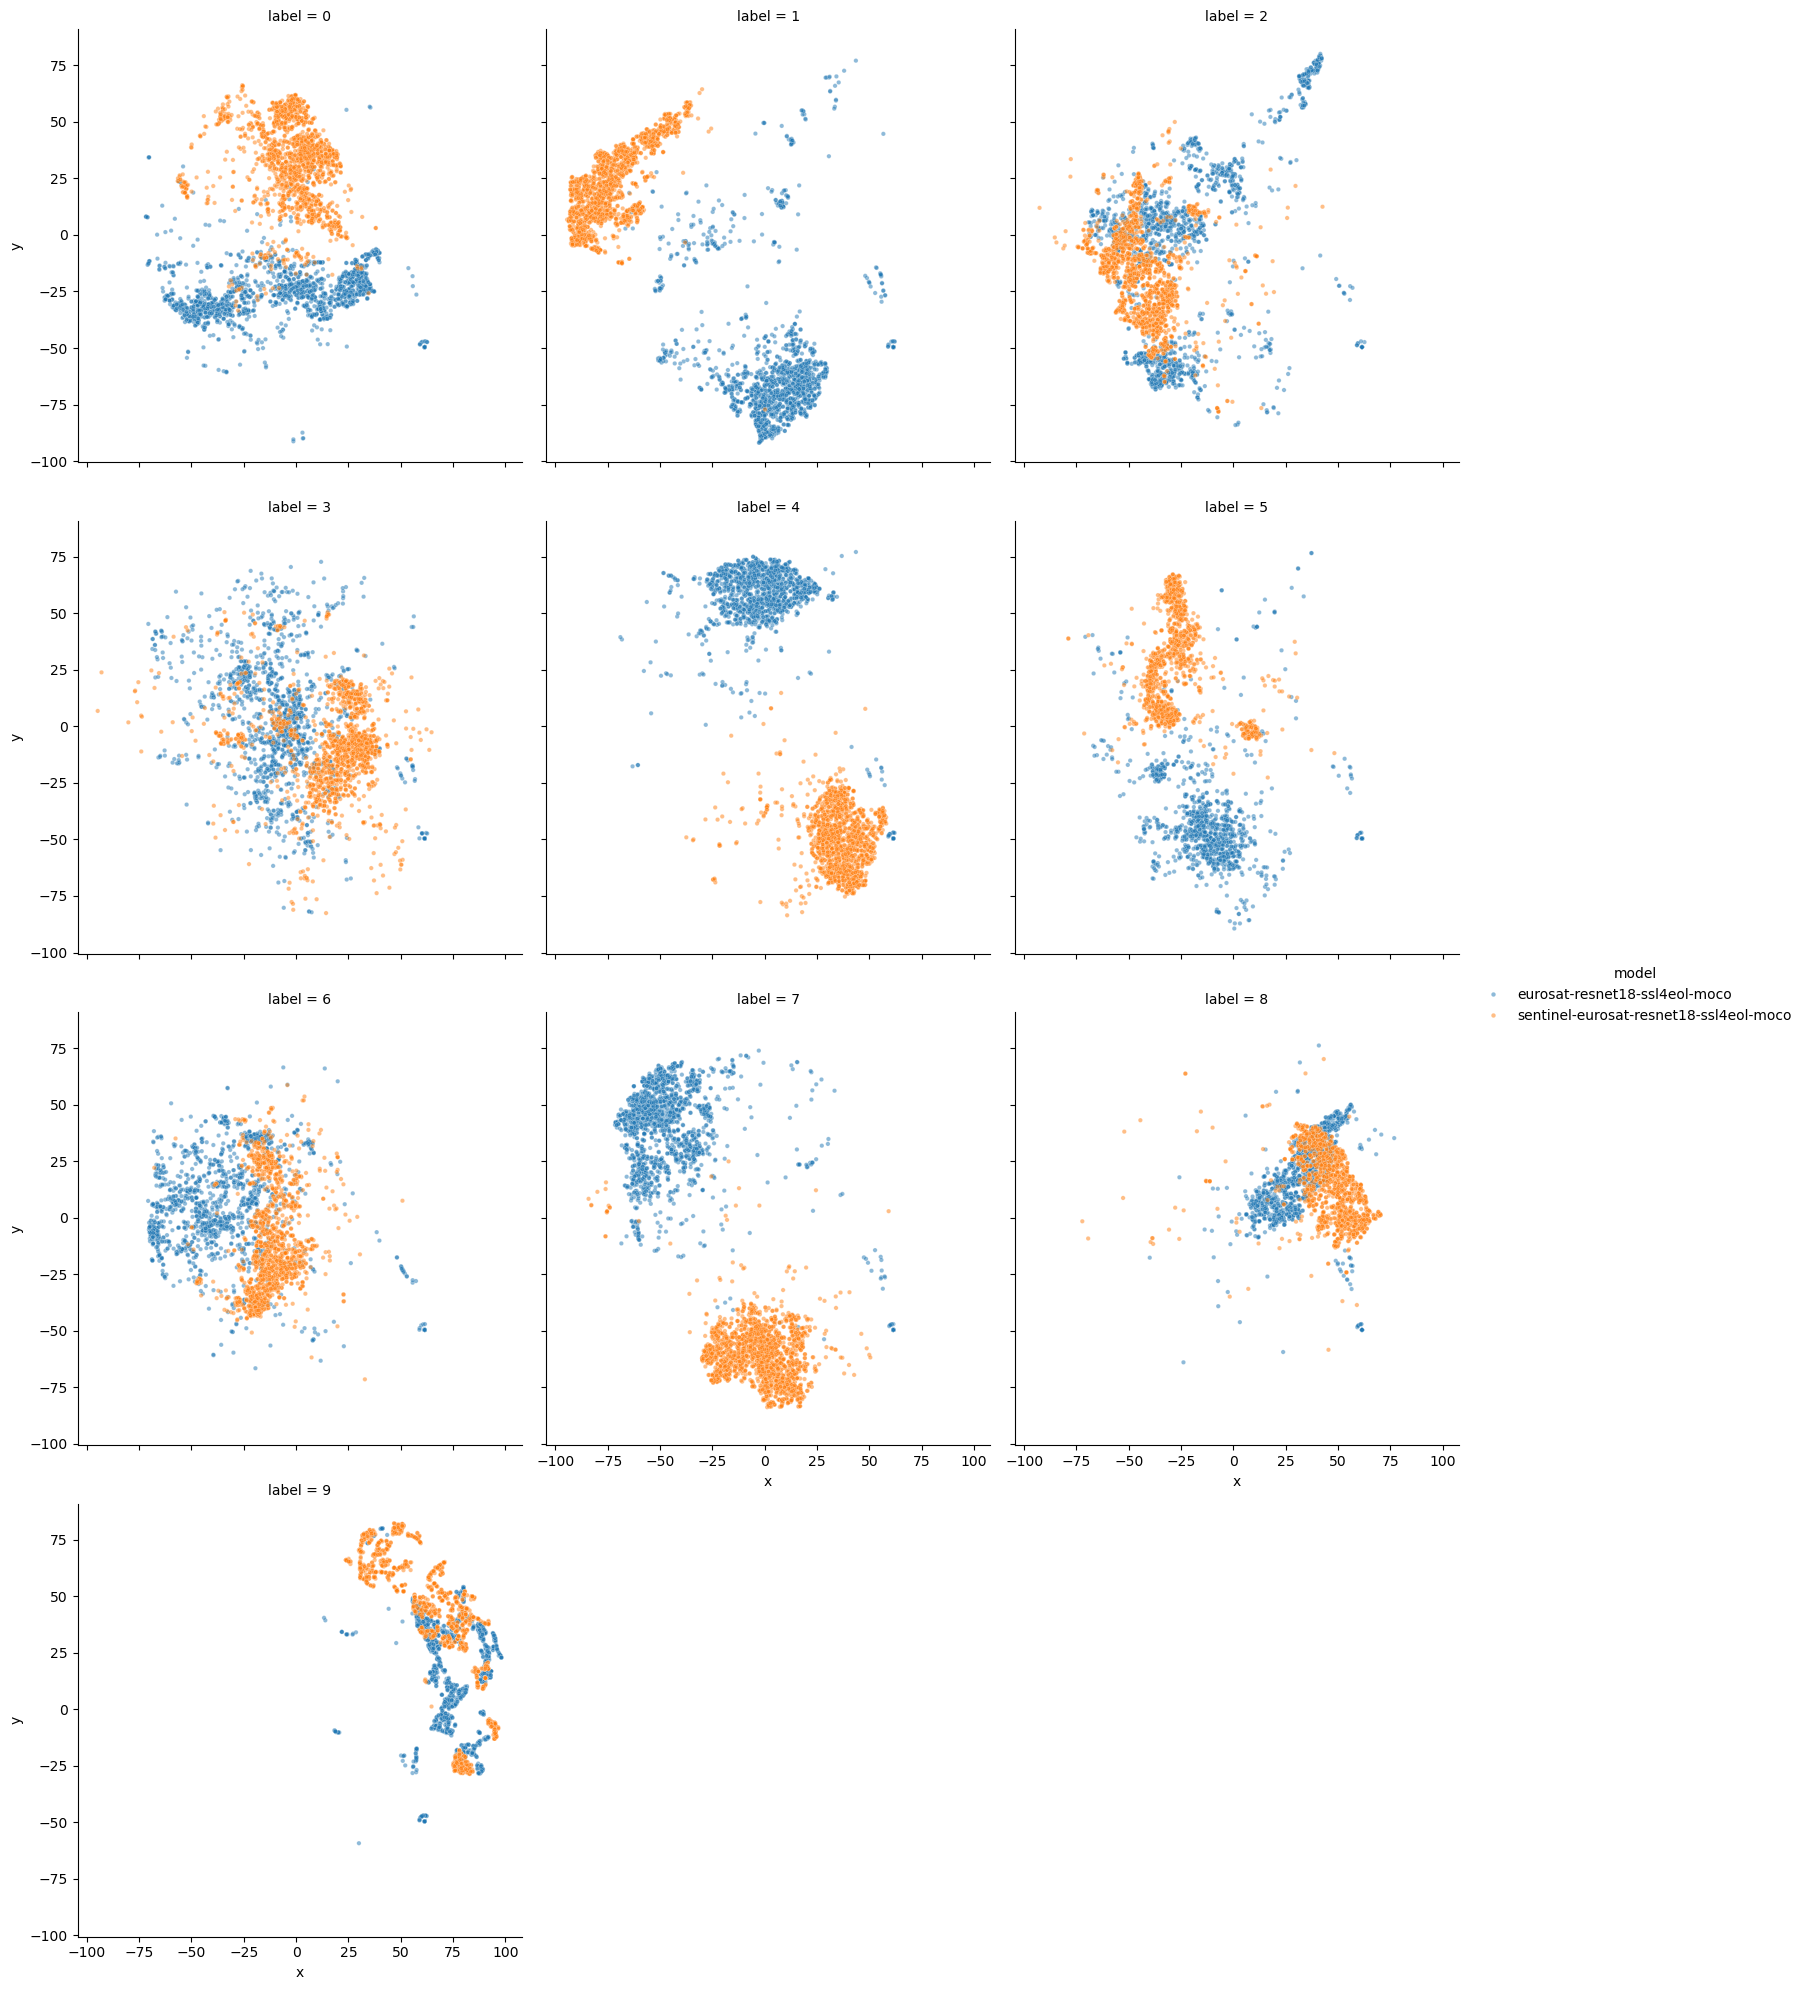

In [40]:
import seaborn as sns

sns.relplot(
    data=tnse_df,
    x="x",
    y="y",
    hue="model",
    col="label",
    col_wrap=3,
    alpha=0.5,
    s=10,
)

In [96]:
filename = "embeddings_translated/sentinel-eurosat-resnet50-ssl4eol-moco_to_eurosat-resnet50-ssl4eol-moco_translated_train.npz"

embeddings = np.load(filename)
x_train, y_train = (
    embeddings["landsat_to_sentinel"],
    embeddings["labels"],
)

filename = "embeddings_translated/sentinel-eurosat-resnet50-ssl4eol-moco_to_eurosat-resnet50-ssl4eol-moco_translated_test.npz"

embeddings = np.load(filename)
x_test, y_test = (
    embeddings["landsat_to_sentinel"],
    embeddings["labels"],
)


In [97]:
metrics = eval_knn(x_train, y_train, x_test, y_test, k=k, scale=False)
metrics

+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+
|   overall_accuracy |   overall_precision |   average_precision |   overall_recall |   average_recall |   overall_f1 |   average_f1 |
+====================+=====================+=====================+==================+==================+==============+==============+
|           0.899815 |            0.899815 |            0.897185 |         0.899815 |         0.893077 |     0.899815 |      0.89428 |
+--------------------+---------------------+---------------------+------------------+------------------+--------------+--------------+


{'overall_accuracy': 0.8998148148148148,
 'overall_precision': 0.8998148148148148,
 'average_precision': 0.8971845857532742,
 'overall_recall': 0.8998148148148148,
 'average_recall': 0.8930774033657242,
 'overall_f1': 0.8998148148148148,
 'average_f1': 0.8942798315650125}